In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
import zipfile
import os
from tqdm import tqdm
from time import perf_counter


In [2]:
import kagglehub


path = kagglehub.dataset_download("abdallahalidev/plantvillage-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/plantvillage-dataset


In [3]:
path = "/kaggle/input/plantvillage-dataset/color"

In [4]:

for class_name in sorted(os.listdir(path)):
    class_path = os.path.join(path, class_name)
    if os.path.isdir(class_path):

        image_count = sum(
            1 for file in os.listdir(class_path)
            if os.path.isfile(os.path.join(class_path, file))
        )
        print(f"{class_name}: {image_count} images")

Apple___Apple_scab: 630 images
Apple___Black_rot: 621 images
Apple___Cedar_apple_rust: 275 images
Apple___healthy: 1645 images
Blueberry___healthy: 1502 images
Cherry_(including_sour)___Powdery_mildew: 1052 images
Cherry_(including_sour)___healthy: 854 images
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 513 images
Corn_(maize)___Common_rust_: 1192 images
Corn_(maize)___Northern_Leaf_Blight: 985 images
Corn_(maize)___healthy: 1162 images
Grape___Black_rot: 1180 images
Grape___Esca_(Black_Measles): 1383 images
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1076 images
Grape___healthy: 423 images
Orange___Haunglongbing_(Citrus_greening): 5507 images
Peach___Bacterial_spot: 2297 images
Peach___healthy: 360 images
Pepper,_bell___Bacterial_spot: 997 images
Pepper,_bell___healthy: 1478 images
Potato___Early_blight: 1000 images
Potato___Late_blight: 1000 images
Potato___healthy: 152 images
Raspberry___healthy: 371 images
Soybean___healthy: 5090 images
Squash___Powdery_mildew: 1835 images
S

In [5]:
import os
import shutil
import random
from pathlib import Path


random.seed(42)


source_dir = '/kaggle/input/plantvillage-dataset/color'
dest_dir   = '/kaggle/working/plantvillage-balanced'
min_required = 350


os.makedirs(dest_dir, exist_ok=True)


class_counts = {}
for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        image_files = [f for f in os.listdir(class_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        class_counts[class_name] = len(image_files)

print("Found classes:", len(class_counts))
print("Counts per class:", class_counts)


kept, skipped = [], []
for class_name, count in class_counts.items():
    src_class_path = os.path.join(source_dir, class_name)
    dst_class_path = os.path.join(dest_dir, class_name)


    if count < min_required:
        skipped.append((class_name, count))
        continue

    os.makedirs(dst_class_path, exist_ok=True)


    image_files = [f for f in os.listdir(src_class_path)
                   if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


    sampled_files = random.sample(image_files, min_required)

    for filename in sampled_files:
        src = os.path.join(src_class_path, filename)
        dst = os.path.join(dst_class_path, filename)
        shutil.copy2(src, dst)

    kept.append((class_name, min_required))

print("\nSummary")
print("---------")
print(f"Kept classes (exactly {min_required} each): {len(kept)}")
for name, cnt in kept:
    print(f"  - {name}: {cnt}")

print(f"\nSkipped classes (< {min_required} images): {len(skipped)}")
for name, cnt in skipped:
    print(f"  - {name}: {cnt}")

print("\nBalanced dataset created at:", dest_dir)


Found classes: 38
Counts per class: {'Tomato___Late_blight': 1909, 'Tomato___healthy': 1591, 'Grape___healthy': 423, 'Orange___Haunglongbing_(Citrus_greening)': 5507, 'Soybean___healthy': 5090, 'Squash___Powdery_mildew': 1835, 'Potato___healthy': 152, 'Corn_(maize)___Northern_Leaf_Blight': 985, 'Tomato___Early_blight': 1000, 'Tomato___Septoria_leaf_spot': 1771, 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 513, 'Strawberry___Leaf_scorch': 1109, 'Peach___healthy': 360, 'Apple___Apple_scab': 630, 'Tomato___Tomato_Yellow_Leaf_Curl_Virus': 5357, 'Tomato___Bacterial_spot': 2127, 'Apple___Black_rot': 621, 'Blueberry___healthy': 1502, 'Cherry_(including_sour)___Powdery_mildew': 1052, 'Peach___Bacterial_spot': 2297, 'Apple___Cedar_apple_rust': 275, 'Tomato___Target_Spot': 1404, 'Pepper,_bell___healthy': 1478, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 1076, 'Potato___Late_blight': 1000, 'Tomato___Tomato_mosaic_virus': 373, 'Strawberry___healthy': 456, 'Apple___healthy': 1645, 'Grape

In [6]:
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


dataset = datasets.ImageFolder(root="/kaggle/working/plantvillage-balanced", transform=transform_train)
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



val_dataset.dataset.transform = transform_test
test_dataset.dataset.transform = transform_test

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class_names = dataset.classes
num_classes = len(class_names)

In [7]:
class_names = dataset.classes
num_classes = len(class_names)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class SelfAttention2D(nn.Module):

    def __init__(self, in_channels, d_model=256, num_heads=4, dropout=0.0):
        super().__init__()
        self.proj_in  = nn.Conv2d(in_channels, d_model, kernel_size=1)
        self.mha      = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads,
                                              dropout=dropout, batch_first=True)
        self.proj_out = nn.Conv2d(d_model, in_channels, kernel_size=1)
        self.norm1    = nn.LayerNorm(d_model)
        self.norm2    = nn.LayerNorm(d_model)
        self.ffn      = nn.Sequential(
            nn.Linear(d_model, 4*d_model),
            nn.GELU(),
            nn.Linear(4*d_model, d_model)
        )
        self.drop = nn.Dropout(dropout)

    def forward(self, x):
        b, c, h, w = x.shape
        y = self.proj_in(x)
        y = y.flatten(2).transpose(1, 2)
        y = self.norm1(y)
        attn_out, _ = self.mha(y, y, y, need_weights=False)
        y = y + self.drop(attn_out)
        y2 = self.ffn(self.norm2(y))
        y = y + self.drop(y2)
        y = y.transpose(1, 2).view(b, -1, h, w)
        y = self.proj_out(y)
        return x + y


class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.BatchNorm2d(32), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.MaxPool2d(2)
        )

      
        self.attn = SelfAttention2D(in_channels=128, d_model=256, num_heads=4, dropout=0.0)

        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(0.2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.attn(x)
        x = self.block4(x)
        x = self.head(x)
        return x


In [9]:
class EarlyStopping:

    def __init__(self, patience=5):

        self.patience = patience
        self.counter = 0
        self.best_loss = np.inf

    def check_early_stop(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [10]:
from time import perf_counter
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

total_train_t0 = perf_counter()
epoch_times = []

num_epochs = 50

model = CustomCNN(num_classes=num_classes).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
early_stopping = EarlyStopping(patience=5)

train_losses, val_losses = [], []

scaler = GradScaler()

for epoch in range(num_epochs):
    t_epoch0 = perf_counter()
    print(f"Epoch {epoch+1}/{num_epochs}")

    model.train()
    train_loss = 0.0
    for images, labels in tqdm(train_loader, desc="Training", leave=False):
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Validation", leave=False):
            images, labels = images.to('cuda'), labels.to('cuda')
            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    print(f"Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")

    t_epoch1 = perf_counter()
    epoch_times.append(t_epoch1 - t_epoch0)
    print(f"Epoch {epoch+1} time: {epoch_times[-1]:.2f} s")

    if early_stopping.check_early_stop(avg_val_loss):
        print("Early stopping triggered.")
        break

total_train_time = perf_counter() - total_train_t0
print(f"Total training wall time: {total_train_time:.2f} s")
avg_epoch_time = sum(epoch_times) / len(epoch_times) if epoch_times else 0.0
print(f"Average per-epoch time: {avg_epoch_time:.2f} s")


/tmp/ipykernel_19/2140988257.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()


Epoch 1/50


Training:   0%|          | 0/276 [00:00<?, ?it/s]/tmp/ipykernel_19/2140988257.py:28: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
Validation:   0%|          | 0/79 [00:00<?, ?it/s]/tmp/ipykernel_19/2140988257.py:41: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Train Loss: 1.6704, Validation Loss: 1.2530
Epoch 1 time: 55.74 s
Epoch 2/50


Train Loss: 0.7974, Validation Loss: 0.8761
Epoch 2 time: 54.54 s
Epoch 3/50


Train Loss: 0.5386, Validation Loss: 0.5781
Epoch 3 time: 54.27 s
Epoch 4/50


Train Loss: 0.4278, Validation Loss: 0.6842
Epoch 4 time: 54.46 s
Epoch 5/50


Train Loss: 0.3804, Validation Loss: 0.3944
Epoch 5 time: 54.55 s
Epoch 6/50


Train Loss: 0.3035, Validation Loss: 0.3696
Epoch 6 time: 54.51 s
Epoch 7/50


Train Loss: 0.2845, Validation Loss: 0.2495
Epoch 7 time: 54.55 s
Epoch 8/50


Train Loss: 0.2471, Validation Loss: 0.4359
Epoch 8 time: 54.68 s
Epoch 9/50


Train Loss: 0.2452, Validation Loss: 0.2963
Epoch 9 time: 54.71 s
Epoch 10/50


Train Loss: 0.2026, Validation Loss: 0.4113
Epoch 10 time: 53.99 s
Epoch 11/50


Train Loss: 0.1835, Validation Loss: 0.2134
Epoch 11 time: 55.12 s
Epoch 12/50


Train Loss: 0.1632, Validation Loss: 0.2699
Epoch 12 time: 54.66 s
Epoch 13/50


Train Loss: 0.1596, Validation Loss: 0.3345
Epoch 13 time: 54.90 s
Epoch 14/50


Train Loss: 0.1528, Validation Loss: 0.5660
Epoch 14 time: 54.68 s
Epoch 15/50


Train Loss: 0.1732, Validation Loss: 0.2125
Epoch 15 time: 54.62 s
Epoch 16/50


Train Loss: 0.1263, Validation Loss: 0.4717
Epoch 16 time: 53.69 s
Epoch 17/50


Train Loss: 0.1251, Validation Loss: 0.2313
Epoch 17 time: 53.89 s
Epoch 18/50


Train Loss: 0.1280, Validation Loss: 0.1825
Epoch 18 time: 54.81 s
Epoch 19/50


Train Loss: 0.1171, Validation Loss: 0.3724
Epoch 19 time: 55.02 s
Epoch 20/50


Train Loss: 0.1172, Validation Loss: 0.1844
Epoch 20 time: 54.90 s
Epoch 21/50


Train Loss: 0.0862, Validation Loss: 0.1970
Epoch 21 time: 54.89 s
Epoch 22/50


Train Loss: 0.1002, Validation Loss: 0.1791
Epoch 22 time: 54.55 s
Epoch 23/50


Train Loss: 0.1077, Validation Loss: 0.1897
Epoch 23 time: 54.79 s
Epoch 24/50


Train Loss: 0.1109, Validation Loss: 0.2286
Epoch 24 time: 54.63 s
Epoch 25/50


Train Loss: 0.0926, Validation Loss: 0.2417
Epoch 25 time: 54.50 s
Epoch 26/50


Train Loss: 0.0825, Validation Loss: 0.1824
Epoch 26 time: 54.64 s
Epoch 27/50


Train Loss: 0.0916, Validation Loss: 0.1670
Epoch 27 time: 54.56 s
Epoch 28/50


Train Loss: 0.0814, Validation Loss: 0.1986
Epoch 28 time: 54.54 s
Epoch 29/50


Train Loss: 0.0741, Validation Loss: 0.2304
Epoch 29 time: 54.61 s
Epoch 30/50


Train Loss: 0.0946, Validation Loss: 0.4501
Epoch 30 time: 55.04 s
Epoch 31/50


Train Loss: 0.1017, Validation Loss: 0.2257
Epoch 31 time: 54.74 s
Epoch 32/50


Train Loss: 0.0727, Validation Loss: 0.1767
Epoch 32 time: 55.02 s
Early stopping triggered.
Total training wall time: 1749.04 s
Average per-epoch time: 54.65 s


In [11]:

model_save_path = "custom_cnn_model.pth"


torch.save(model.state_dict(), model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to custom_cnn_model.pth


In [12]:
from sklearn.metrics import classification_report

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        with autocast():
            outputs = model(images)
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


report = classification_report(all_labels, all_preds, digits=4)
print("Classification Report:\n", report)


/tmp/ipykernel_19/277425719.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Classification Report:
               precision    recall  f1-score   support

           0     0.9848    0.9848    0.9848        66
           1     0.9753    0.9875    0.9814        80
           2     0.9516    0.9077    0.9291        65
           3     0.9853    0.9178    0.9504        73
           4     0.9623    0.9808    0.9714        52
           5     1.0000    0.8732    0.9323        71
           6     0.9706    0.9565    0.9635        69
           7     0.9872    1.0000    0.9935        77
           8     0.9589    0.9589    0.9589        73
           9     1.0000    1.0000    1.0000        68
          10     0.9833    0.9516    0.9672        62
          11     1.0000    0.9483    0.9735        58
          12     0.9500    1.0000    0.9744        76
          13     1.0000    0.8421    0.9143        76
          14     0.8904    1.0000    0.9420        65
          15     1.0000    0.9041    0.9496        73
          16     0.9750    1.0000    0.9873        78
   

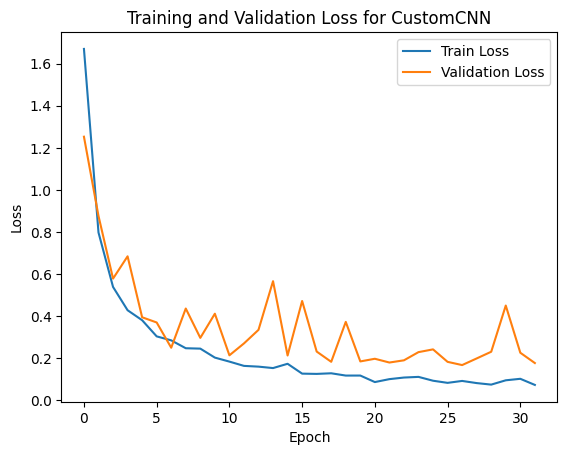

In [13]:

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training and Validation Loss for CustomCNN")
plt.show()

/tmp/ipykernel_19/1131777004.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device.type == "cuda")):


Total test inference time: 3.84 s for 1260 images
Average per-image inference time: 3.05 ms

Classification Report (test):
              precision    recall  f1-score   support

           0     0.9714    1.0000    0.9855        34
           1     0.9600    0.9600    0.9600        25
           2     0.9118    0.9688    0.9394        32
           3     1.0000    0.9189    0.9577        37
           4     0.9796    0.9796    0.9796        49
           5     0.9600    0.8276    0.8889        29
           6     0.9512    0.9750    0.9630        40
           7     1.0000    1.0000    1.0000        36
           8     0.9583    0.9200    0.9388        25
           9     1.0000    1.0000    1.0000        33
          10     0.9643    0.9310    0.9474        29
          11     1.0000    0.9211    0.9589        38
          12     0.9394    1.0000    0.9688        31
          13     1.0000    0.8056    0.8923        36
          14     0.9143    1.0000    0.9552        32
          15

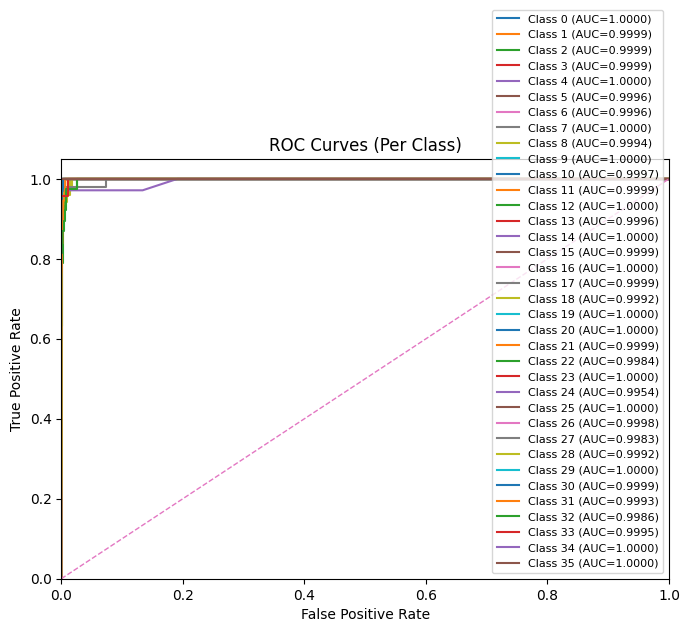

In [14]:
import time
import numpy as np
import torch
import torch.nn.functional as F
from torch.cuda.amp import autocast
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc, classification_report
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from time import perf_counter

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.eval().to(device)

all_probs = []
all_preds = []
all_labels = []

test_infer_t0 = perf_counter()
test_images_count = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        test_images_count += images.size(0)
        with autocast(enabled=(device.type == "cuda")):
            logits = model(images)
        probs = F.softmax(logits, dim=1).detach().cpu().numpy()
        preds = np.argmax(probs, axis=1)
        all_probs.append(probs)
        all_preds.append(preds)
        all_labels.append(labels.detach().cpu().numpy())

test_infer_t1 = perf_counter()
total_test_infer_time = test_infer_t1 - test_infer_t0
avg_per_image_ms = (total_test_infer_time / test_images_count) * 1000.0

all_probs = np.concatenate(all_probs, axis=0) if len(all_probs) > 0 else np.empty((0, 0))
all_preds = np.concatenate(all_preds, axis=0) if len(all_preds) > 0 else np.empty((0,))
all_labels = np.concatenate(all_labels, axis=0) if len(all_labels) > 0 else np.empty((0,))

print(f"Total test inference time: {total_test_infer_time:.2f} s for {test_images_count} images")
print(f"Average per-image inference time: {avg_per_image_ms:.2f} ms")

print("\nClassification Report (test):")
print(classification_report(all_labels, all_preds, digits=4))

if all_probs.size > 0:
    n_classes = all_probs.shape[1]
    classes = np.arange(n_classes)
    y_bin = label_binarize(all_labels, classes=classes)
    fpr = {}
    tpr = {}
    roc_auc = {}
    for c in classes:
        fpr[c], tpr[c], _ = roc_curve(y_bin[:, c], all_probs[:, c])
        roc_auc[c] = auc(fpr[c], tpr[c])
    plt.figure(figsize=(7, 6))
    for c in classes:
        plt.plot(fpr[c], tpr[c], lw=1.5, label=f"Class {c} (AUC={roc_auc[c]:.4f})")
    plt.plot([0, 1], [0, 1], lw=1, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Per Class)")
    plt.legend(loc="lower right", fontsize=8)
    plt.tight_layout()
    plt.show()


In [15]:
!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git


!pip install lime

  Cloning https://github.com/jacobgil/pytorch-grad-cam.git to /tmp/pip-req-build-7r1e6z9j
  Running command git clone --filter=blob:none --quiet https://github.com/jacobgil/pytorch-grad-cam.git /tmp/pip-req-build-7r1e6z9j
  Resolved https://github.com/jacobgil/pytorch-grad-cam.git to commit 781dbc0d16ffa95b6d18b96b7b829840a82d93d1
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 101.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.

In [16]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget


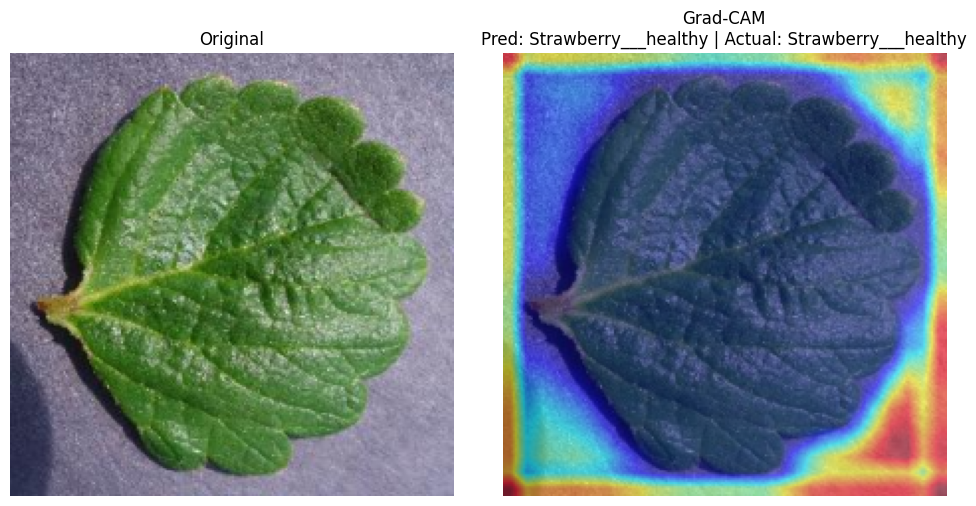

In [17]:
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt


model.eval().to('cuda')


sample_image, label = test_dataset[0]
sample_image = sample_image.unsqueeze(0).to('cuda')


original_image_np = sample_image.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
original_image_np = (original_image_np * 0.5) + 0.5
original_image_np = original_image_np.clip(0, 1)


target_layers = [model.block4[0]]


cam = GradCAM(model=model, target_layers=target_layers)


outputs = model(sample_image)
predicted_class = outputs.argmax(dim=1).item()


targets = [ClassifierOutputTarget(predicted_class)]


grayscale_cam = cam(input_tensor=sample_image, targets=targets, eigen_smooth=True)
heatmap = grayscale_cam[0]


result = show_cam_on_image(original_image_np, heatmap, use_rgb=True)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.title("Original"); plt.imshow(original_image_np); plt.axis('off')
plt.subplot(1,2,2); plt.title(f"Grad-CAM\nPred: {class_names[predicted_class]} | Actual: {class_names[label]}"); 
plt.imshow(result); plt.axis('off')
plt.tight_layout(); plt.show()
